In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from timefusion import TimeFusion
import random


In [2]:
# Create dataset of two correlated, random walks on top of sine functions
# Set random seed to make result reproducible
np.random.seed(0)

# Random walk starts at 0,0
z = np.array([0,0])

# Covariance matrix for normal distribution
cov = [
    [1, 0.5],
    [0.5, 1]
]

# List to hold samples
samples = []

for i in range(10000):

    # Calculate underlying sine values
    y = 30*np.array([np.sin(0.02*i),np.sin((0.03*i + 1))])

    # Draw random samples from normal distribution
    z = np.random.multivariate_normal(z,cov)

    # Store samples
    samples.append(y + z)

# Create pandas DataFrame out of data
data = pd.DataFrame(data=samples,columns=["sine1","sine2"])

# Remove 50% of samples to make into an irregular time-series
keep = 0.5 # What fraction of cells to keep
mask = [True]*int(2*len(data)*keep) + [False]*int(2*len(data)*(1-keep))
random.shuffle(mask)
mask = np.array(mask).reshape((len(data),2))
data = data.mask(mask)

# Remove all rows without any data
data = data.dropna(axis = 0, how = 'all')


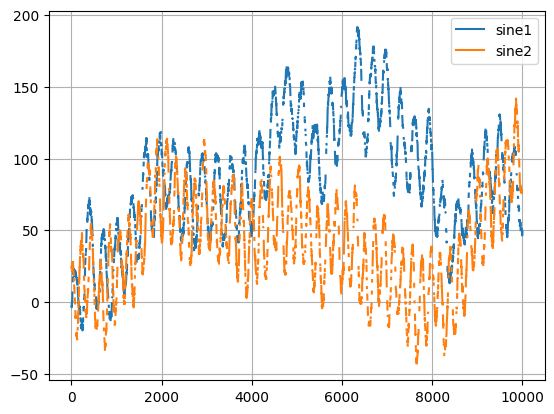

In [3]:
# Plot data so we can inspect it
data.plot()
plt.grid(True)

In [18]:
data

,sine1,sine2
0,-0.524940,24.567550
1,0.891261,26.913557
2,0.982413,27.568898
3,2.271486,28.852528
4,2.652078,30.103996
...,...,...
9995,162.935939,1.455623
9996,163.664274,4.124037
9997,163.360258,5.102300
9998,165.858591,8.145545


In [15]:
for column in data:
    print(data[column].dropna().index[:20][-1])
    print(data[column].dropna().index[-20:][0])

32
9956
40
9949


In [30]:
data.index[pd.Series(data.index).between(3,50)]

Int64Index([ 3,  4,  6,  7, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24,
            25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42,
            43, 44, 45, 46, 47, 49, 50],
           dtype='int64')

AttributeError: 'Int64Index' object has no attribute 'iloc'